In [1]:
import pandas as pd
import os
import plotting
import importlib
importlib.reload(plotting)
import math
from typing import List

# Load in all depth vs resistance curves into a dataframe list

In [2]:
def load_data(data_src):
    depth_resist_curve_df_list = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        depth_resist_curve_df_list.append(df)
        filename_list.append(filename)
    return depth_resist_curve_df_list, filename_list

data_src = "data/cleaned_data"
depth_resist_curve_df_list, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, depth_resist_curve_df_list))

# Seperate clustering data from meta-data

In [3]:
data_features_df = pd.read_csv("data/features.csv")
metadata_list = ['filenames', 'feifeis_ylabels', 'liams_ylabels', 'marions_ylabels', 'distances']
clustering_features_df = data_features_df.drop(metadata_list, axis=1)

# Labels Mapped to Label Numbers

In [4]:
label_to_cluster_num = {'ES-B':0, 'ES':1, 'F':2, 'ES-BW':3, 'ES-D':4, 'LS':5, 'ES-S':6, 'LS/F':7}

# Plotting Marion's Labels

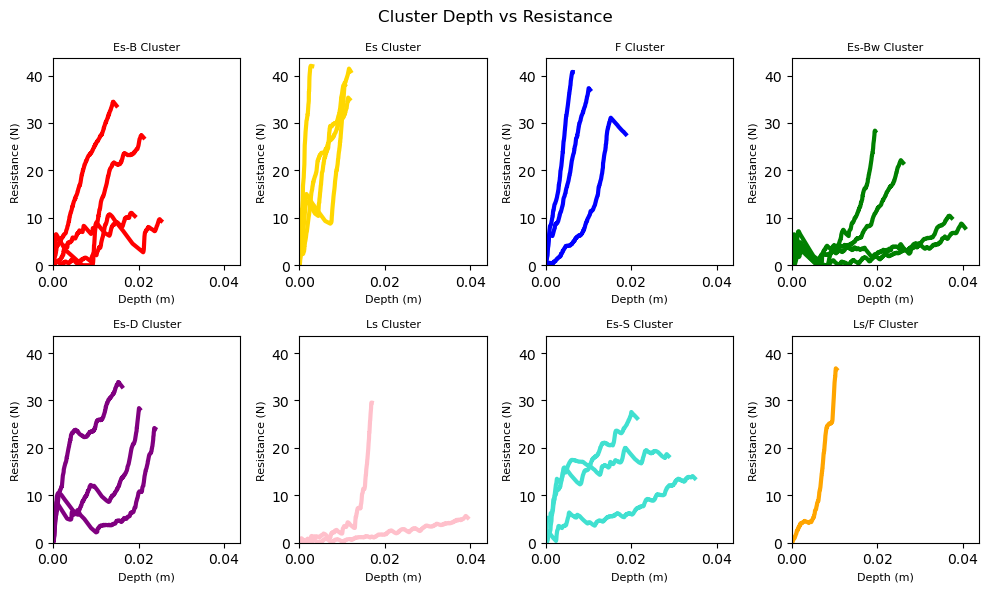

In [5]:
marions_labeled_data = data_features_df[data_features_df['marions_ylabels'].notna()].copy() # removes NaN's which correspond to non-labled data
marions_labeled_data['encoded'] = marions_labeled_data['marions_ylabels'].map(label_to_cluster_num)
uniques = marions_labeled_data['marions_ylabels'].unique().tolist()
plotting.plot_clusters_seperately(marions_labeled_data['encoded'].tolist(), marions_labeled_data.index.tolist(), depth_resist_curve_df_list, 
                         cluster_category_names=uniques, pseudo_corrections=marions_labeled_data)


# Marion's Centroid Clustering

In [6]:
"""Assumes encoded exists within labeled data"""
def find_labels_centroids(labeled_data: pd.DataFrame, label_to_cluster_num:dict[str,int]) -> pd.DataFrame:
    # remove non-important cols
    labeled_data = labeled_data.copy()
    numerical_data = plotting.extract_numerical_features(labeled_data)
    label_centroids = []
    for label_name, label_num in label_to_cluster_num.items():
        label_data = numerical_data[labeled_data['encoded'] == label_num]
        label_centroid = label_data.mean(axis=0).tolist() # drop cols for mean calculation
        label_centroid.extend([label_name, label_num]) # append these onto the end
        label_centroids.append(label_centroid)
    return_cols = numerical_data.columns.tolist()
    return_cols.extend(['ylabels', 'encoded'])
    return pd.DataFrame(data=label_centroids, columns=return_cols)

def euclidean_distance(x: pd.Series, y: pd.Series) -> float:
    return math.sqrt(((y - x) ** 2).sum())

def find_closest_centroid(unlabeled_data_df:pd.DataFrame, marions_centroids:pd.DataFrame) -> pd.DataFrame:
    unlabeled_data_df = unlabeled_data_df.copy()
    unlabeled_data_df = plotting.extract_numerical_features(unlabeled_data_df)
    
    pseudo_label_list = []
    pseudo_label_num_list = []
    unlabeled_data_df = unlabeled_data_df.copy()
    for i, depth_res_curve in unlabeled_data_df.iterrows():
        min_distance = float('inf')
        min_distance_label = ''
        min_distance_label_num = 0
        for j, marions_label_mean in marions_centroids.iterrows():
            curve_to_label_mean_distance = euclidean_distance(depth_res_curve, marions_label_mean)
            if curve_to_label_mean_distance < min_distance:
                min_distance = curve_to_label_mean_distance
                min_distance_label = marions_label_mean['ylabels']
                min_distance_label_num = j
        pseudo_label_list.append(min_distance_label)
        pseudo_label_num_list.append(min_distance_label_num)
    unlabeled_data_df['pseudo_ylabels'] = pseudo_label_list
    unlabeled_data_df['encoded'] = pseudo_label_num_list
    return unlabeled_data_df

# marions_label_centroids = find_labels_centroids(marions_labeled_data, label_to_cluster_num)
# pseudo_labeled_data = find_closest_centroid(data_features_df, marions_label_centroids)

# Find curves that moved categories

In [7]:
def find_changed_label_curves(labeled_data:pd.DataFrame, pseudo_labeled_data:pd.DataFrame):
    ylabel_indicies = labeled_data.index # indicies of labeled data points
    pseudo_labels_of_labeled_data = pseudo_labeled_data.loc[ylabel_indicies]
    diff_mask = (labeled_data['ylabels'] != pseudo_labels_of_labeled_data['pseudo_ylabels'])
    changed_label_indicies = labeled_data[diff_mask].index.tolist()
    return changed_label_indicies
# changed_label_indicies = find_changed_label_curves(marions_labeled_data, pseudo_labeled_data)

# Plotting with correction of labeled curves moving categories

In [8]:
# # plotting.pca_analysis(pseudo_labeled_data)
# corrected_pseudo_labeling = pseudo_labeled_data.copy()

# # correct movements of curves
# corrected_pseudo_labeling.loc[changed_label_indicies, 'marions_pseudo_labels'] = marions_labeled_data['marions_ylabels']
# corrected_pseudo_labeling.loc[changed_label_indicies, 'encoded'] = marions_labeled_data['encoded']

# # plotting.plot_pca(corrected_pseudo_labeling, corrected_pseudo_labeling['encoded'], 3, 
# #     graph_title='marions_pseudo_labels', centroids=marions_label_centroids)
# plotting.plot_clusters_seperately(corrected_pseudo_labeling['encoded'], corrected_pseudo_labeling.index, 
#                                   depth_resist_curve_df_list, cluster_category_names=marions_label_centroids['ylabels'].tolist(),
#                                   pseudo_corrections=marions_labeled_data)

# Plotting with no correction of labeled curves moving categories

In [9]:
# # plotting.pca_analysis(pseudo_labeled_data)
# uncorrected_pseudo_labeling = pseudo_labeled_data.copy()

# def print_pseudo_label_changes(changed_label_indicies:List[int], marions_labeled_data:pd.DataFrame, pseudo_labeled_data:pd.DataFrame, filename_list: List[str]):
#     for idx in changed_label_indicies:
#         print(f'{filename_list[idx]} changed label from actual {marions_labeled_data.loc[idx]['marions_ylabels']} to pseudo {pseudo_labeled_data.loc[idx]['pseudo_labels']}')

# print_pseudo_label_changes(changed_label_indicies, marions_labeled_data, pseudo_labeled_data, filename_list)

# # plotting.plot_pca(uncorrected_pseudo_labeling, uncorrected_pseudo_labeling['encoded'], 3, 
# #     graph_title='marions_pseudo_labels', centroids=marions_label_centroids)
# pseudo_corrections = marions_labeled_data.loc[changed_label_indicies]
# plotting.plot_clusters_seperately(uncorrected_pseudo_labeling['encoded'], uncorrected_pseudo_labeling.index, 
#                                   depth_resist_curve_df_list, cluster_category_names=marions_label_centroids['ylabels'].tolist(),
#                                   pseudo_corrections=pseudo_corrections)

# Plot marions ylabels 2

In [10]:
marions_labeled_data_2 = data_features_df[data_features_df['marions_ylabels_2'].notna()].copy()

label_to_cluster_num = {'ES-B':0, 'ES':1, 'F':2, 'ES-BW':3, 'ES-D':4, 'LS':5, 'ES-S':6, 'LS/F':7, 'ES-DB':8}
marions_labeled_data_2['encoded'] = marions_labeled_data_2['marions_ylabels_2'].map(label_to_cluster_num)
# print(marions_labeled_data_2[['marions_ylabels_2', 'filenames']])
marions_label_centroids_2 = find_labels_centroids(marions_labeled_data_2, label_to_cluster_num)

print(f'Plotting only the labeled data')
# plotting.plot_clusters_seperately(marions_labeled_data_2['encoded'].tolist(), marions_labeled_data_2.index.tolist(), depth_resist_curve_df_list, 
#                          cluster_category_names=list(label_to_cluster_num.keys()), pseudo_corrections=marions_labeled_data_2)
# plotting.plot_pca(marions_labeled_data_2, marions_labeled_data_2['encoded'], 3, 
#     graph_title='marions_labeled_data_2', centroids=marions_label_centroids_2)

# -----------------------------------------------

print(f'Plotting Uncorrected Pseudo Labels')

print(marions_labeled_data_2[['marions_ylabels_2']])
pseudo_labeled_data_2 = find_closest_centroid(data_features_df, marions_label_centroids_2)
print(pseudo_labeled_data_2[['pseudo_ylabels']].loc[marions_labeled_data_2.index])
changed_labels_indicies = find_changed_label_curves(marions_labeled_data_2, pseudo_labeled_data_2, label_name='marions_ylabels2')

print(f'changed_labels_indicies: {changed_labels_indicies}')
# print(marions_labeled_data_2.loc[changed_labels_indicies]['marions_ylabels_2'])
pseudo_corrections = marions_labeled_data_2.loc[changed_labels_indicies]
# corrected_pseudo_labeling = pseudo_labeled_data_2.copy()
# corrected_pseudo_labeling.loc[changed_label_indicies, 'pseudo_labels'] = marions_labeled_data_2['marions_ylabels_2']
# corrected_pseudo_labeling.loc[changed_label_indicies, 'encoded'] = marions_labeled_data_2['encoded']


plotting.plot_clusters_seperately(pseudo_labeled_data_2['encoded'].tolist(), pseudo_labeled_data_2.index.tolist(), depth_resist_curve_df_list,
                                  cluster_category_names=list(label_to_cluster_num.keys()), pseudo_corrections=pseudo_corrections)
plotting.plot_pca(pseudo_labeled_data_2, pseudo_labeled_data_2['encoded'], 3, 
    graph_title='marions_pseudo_labels_2', centroids=marions_label_centroids_2)

Plotting only the labeled data
Plotting Uncorrected Pseudo Labels
   marions_ylabels_2
0               ES-B
2                 LS
8                 ES
11                 F
12              ES-S
13              ES-S
15              ES-S
16              ES-D
19              ES-D
20             ES-DB
22                LS
25                ES
26              ES-B
27              ES-D
30             ES-DB
33              ES-D
35             ES-BW
37              ES-D
39              ES-B
41                LS
43                 F
44                LS
46              ES-S
47              ES-D
48                ES
49              ES-B
50             ES-BW
53             ES-BW
54              ES-D
55              ES-D
56                 F
62                LS
63             ES-BW
65              ES-S
66              ES-S
67              LS/F
68              ES-S
71                ES
72              ES-D
74              ES-D
77              ES-D
   pseudo_ylabels
0               F
2              L

TypeError: find_changed_label_curves() got an unexpected keyword argument 'label_name'